<a href="https://colab.research.google.com/github/raenoh/AndroidWearable-Samples/blob/master/SOLVED_Flower_Hands_on_Tutorial_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flower Hands on Coding Challange

Welcome to Flower Hands-on Tutorial!

In this notebook, you'll build a federated learning system using **Flower** and **PyTorch** with **MNIST** dataset.

We will provide you with the following code:
* ML model definition,
* train, test functions.

You will need to implement the following elements:
* data division (clients partitioning and train/test division),
* Flower Client class,
* Flower Strategy (initialization or groud-up creation),
* distributed evaluation,
* centralized evaluation.


### Install dependencies & Import libraries

Next, we install the necessary packages
* Flower (`flwr`),
* PyTorch (`torch`, `torchvision`),

In [ ]:
!pip install -q flwr[simulation] torch torchvision matplotlib;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.2/157.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 12.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.9

Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [ ]:
from collections import OrderedDict
from typing import List, Tuple, Dict, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torch.utils.data import ConcatDataset, DataLoader, Dataset, Subset, random_split

import flwr as fl
from flwr.common import Metrics
from flwr.common.typing import NDArrays, Scalar

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)


Training on cpu using PyTorch 2.0.1+cu118 and Flower 1.4.0


Let's define some useful constants that we will need along the tutorial.

In [ ]:
SEED = 42
NUM_CLIENTS = 10
BATCH_SIZE = 32
VALID_FRACTION = 0.2 # fraction of the dataset used for each local client
NUM_ROUNDS = 2

## Data

The aim of this section is to create a divided MNIST dataset to simulate the federated learning evironment.

We provide you with the `download_data` function and want you to implement the following:

* `partition_data`,
* `train_val_divide_local_datasets`.

You are given the function prototype - function name, the necessary information about a function, arguments, their types, and the return type.

If implemented correctly they should be able to run `load_datasets` function that creates the divided datasets.

Firstly let's just have a quick look at the data (already prepared, just run the cells below).

In [ ]:
def download_data() -> Tuple[Dataset, Dataset]:
    transform = transforms.Compose(
        [transforms.ToTensor(),]# transforms.Normalize((0.1307,), (0.3081,))
    )
    trainset = MNIST("./dataset", train=True, download=True, transform=transform)
    testset = MNIST("./dataset", train=False, download=True, transform=transform)
    return trainset, testset
# Keep the testset for centralized (optional) centralized evaluation.
trainset, testset = download_data()

100%|██████████| 9912422/9912422 [00:00<00:00, 101700593.79it/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 53176336.18it/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24754514.11it/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 16681723.96it/s]


Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



### Quick EDA

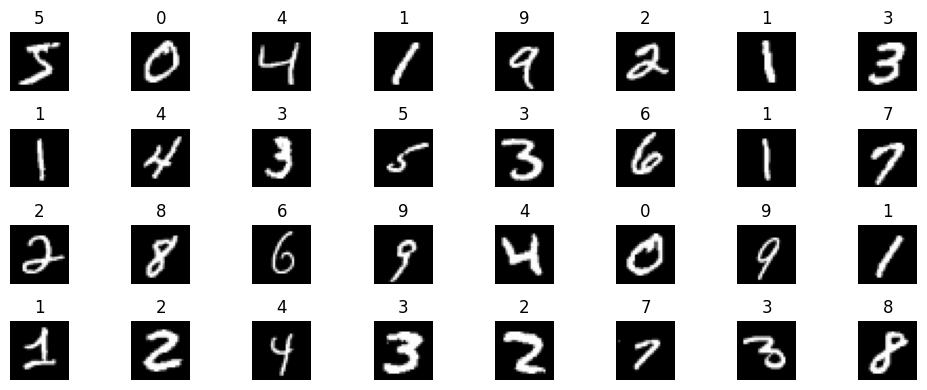

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(torch.utils.data.DataLoader(trainset, batch_size=64))
images, labels = next(dataiter)
images = images.permute(0, 2, 3, 1).numpy()

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(10, 4))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(labels[i].numpy())
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()


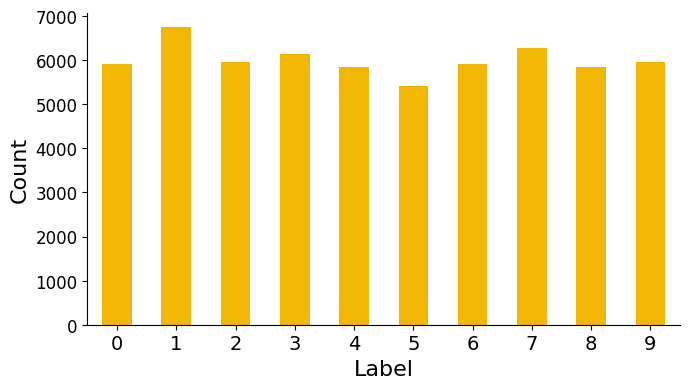

In [ ]:
labels = pd.Series([label for _, label in trainset])
counts = labels.value_counts().sort_index()
counts.plot.bar(figsize=(7, 4), color=["#F2B705"])
plt.ylabel("Count", fontsize=16)
plt.xlabel("Label", fontsize=16)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=12)
ax = plt.gca()
plt.tight_layout()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

We see that the data is quite evenly distributed. Let's sample the data random - iid sampling.

In [ ]:
def partition_data(dataset: Dataset, n_partitions: int) -> List[Dataset]:
    """
    Split the dataset into iid partitions to simulate federated learning.

    Returns
    -------
    List[Dataset]
        A list of dataset (one dataset for every client)
    """
    partition_size = int(len(dataset) / n_partitions)
    lengths = [partition_size] * n_partitions
    datasets = random_split(dataset, lengths, torch.Generator().manual_seed(SEED))
    return datasets

In [ ]:
def train_val_divide_local_datasets(local_datasets: List[Dataset], valid_fraction: float) -> Tuple[List[Dataset], List[Dataset]]:
    """Split each local dataset into train and validation."""
    trainloaders = []
    validloaders = []

    for dataset in local_datasets:
        validation_lenght = int(len(dataset) * valid_fraction)
        train_length = len(dataset) - validation_lenght
        lengths = [train_length, validation_lenght]
        train_dataset, validation_dataset = random_split(
            dataset, lengths, torch.Generator().manual_seed(SEED)
        )
        trainloaders.append(DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True))
        validloaders.append(DataLoader(validation_dataset, batch_size=BATCH_SIZE))

    return trainloaders, validloaders

In [ ]:
def load_datasets(n_partitions: int, valid_fraction: float, batch_size:int) -> Tuple[List[DataLoader], List[DataLoader], DataLoader]:
    """Handles the MNIST data creation for federated learning.

    It starts from downloading, thought partitioning, train test division and centralized dataset creation.

    Parameters
    ----------
    n_partitions: int
        The number of partitions the MNIST train set is divided into.
    valid_split: float
        The fraction of the validaiton data in each local dataset.
    batch_size: int
        The size of batch.

    Returns
    -------
    Tuple[List[DataLoader], List[DataLoader], DataLoader]
        Local train datasets, local validation datasets, and a centralized dataset
    """
    # DO NOT MODIFY THIS CODE
    trainset, testset = download_data()
    local_datasets = partition_data(trainset, n_partitions)
    trainloaders, validloaders = train_val_divide_local_datasets(local_datasets, valid_fraction)
    centralized_loader = DataLoader(testset, batch_size=batch_size)
    return trainloaders, validloaders, centralized_loader

In [ ]:
# DO NOT MODIFY THIS CODE
trainloaders, validloaders, centralized_loader = load_datasets(
    n_partitions=NUM_CLIENTS,
    valid_fraction=VALID_FRACTION,
    batch_size=BATCH_SIZE)

In [ ]:
assert len(trainloaders) == NUM_CLIENTS, f"The number of train partitions should be equal to the number of clients = {NUM_CLIENTS} but is {len(trainloaders)} instead"
assert len(validloaders) == NUM_CLIENTS, f"The number of validation partitions should be equal to the number of clients = {NUM_CLIENTS} but is {len(validloaders)} instead"

## Test Solution using Centralized Training

In this section you are not required to implement anything. You can test your solution by doing centralized training on one of the partitions of the data by simply running the code below.



In [ ]:
class Net(nn.Module):
    """Basic CNN implementation"""
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding="same")
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding="same")
        self.fc1 = nn.Linear(64 * 7 * 7, 2048)
        self.fc2 = nn.Linear(2048, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 7 * 7 * 64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

Let's have a look at the usual training and test functions:

In [ ]:
def train(net: nn.Module, trainloader: DataLoader, epochs: int, verbose=False):
    """Train the neural network for a classification task."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net: nn.Module, testloader: DataLoader):
    """Test the neural network used for classification task."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

Run the centralized training.

In [ ]:
trainloader = trainloaders[0]
valloader = validloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, centralized_loader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.04788221110900243, accuracy 0.37083333333333335
Epoch 2: validation loss 0.047523756523927055, accuracy 0.37083333333333335
Epoch 3: validation loss 0.046505961616834006, accuracy 0.37666666666666665
Epoch 4: validation loss 0.04789999047915141, accuracy 0.36333333333333334
Epoch 5: validation loss 0.04795777161916097, accuracy 0.37333333333333335
Final test set performance:
	loss 0.04549221425056457
	accuracy 0.3926


You should see about 59% accuracy after the 5th epoch and 60% on the centralized dataset.

## Federated Learning

Now, we'll move to implementing federated learning system.

You will need to implement `FlowerClinet`, create Flower Strategy e.g. `FedAvg` and start simulation.

### Updating model parameters

In federated learning, the server sends the global model parameters to the client, and the client updates the local model with the parameters received from the server. It then trains the model on the local data (which changes the model parameters locally) and sends the updated/changed model parameters back to the server (or, alternatively, it sends just the gradients back to the server, not the full model parameters).

We need two helper functions to update the local model with parameters received from the server and to get the updated model parameters from the local model: `set_parameters` and `get_parameters`. The following two functions do just that for the PyTorch model above.

The details of how this works are not really important here (feel free to consult the PyTorch documentation if you want to learn more). In essence, we use `state_dict` to access PyTorch model parameter tensors. The parameter tensors are then converted to/from a list of NumPy ndarray's (which Flower knows how to serialize/deserialize):

In [ ]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

### Implement a Flower client

In Flower, we create clients by implementing subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` in this tutorial because it is easier to implement and requires us to write less boilerplate.

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`.

In [ ]:
from flwr.common.typing import NDArrays
class FlowerClient(fl.client.NumPyClient):
    """
    Class representing a single client in FL system, required to use Flower.
    """
    def __init__(self, net: nn.Module, trainloader: DataLoader, valloader: DataLoader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        """Return the current local model parameters"""
        return get_parameters(self.net)

    def fit(self, parameters: NDArrays, config: Dict[str, Scalar]) -> NDArrays:
        """Train the model on the local (train) data.

        Parameters
        ----------
        parameters: NDarrays
            Model parameters (weights) received from the server

        config: Dict[str, Scalar]
            Server based configuration (needed only if you require dynamically changing values).

        Returns
        -------
        NDArrays
            Updated model parameters

        """
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar])-> Tuple[float, int, Dict[str, Scalar]]:
        """Evaluate model using the validation data.

        Parameters
        ----------
         parameters: NDarrays
            Model parameters (weights) received from the server

        config: Dict[str, Scalar]
            Server based configuration (needed only if you require dynamically changing values).

        Returns
        -------
        loss : float
            The evaluation loss of the model on the local dataset.
        num_examples : int
            The number of examples used for evaluation.
        metrics : Dict[str, Scalar]
            A dictionary mapping arbitrary string keys to values of
            type bool, bytes, float, int, or str. It can be used to
            communicate arbitrary values back to the server.
        """
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. Federated learning systems have multiple clients (otherwise, there's not much to federate), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, then we'd have three instances of `FlowerClient`. Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

### Use the Virtual Client Engine

We will simulate a federated learning system with 10 clients on a single machine = 10 instances of `FlowerClient` in memory. Doing this on a single machine.

Flower creates `FlowerClient` instances only when they are actually necessary for training or evaluation by callling `client_fn` that returns a `FlowerClient` instance on demand. After using them for `fit` or `evaluate` they are discarded, so they should not keep any local state.

`client_fn` takes a single argument `cid` - a client ID. The `cid` can be used, for example, to load different local data partitions for different clients.

In [ ]:
# We can use the fact that we are using Jupyter Notebook environment and use the data without providing it as an argument.
def create_client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = validloaders[int(cid)]
    return FlowerClient(net, trainloader, valloader)


### Metrics Aggregation
Flower can automatically aggregate losses returned by individual clients, but it cannot do the same for metrics in the generic metrics dictionary (the one with the `accuracy` key). Metrics dictionaries can contain very different kinds of metrics and even key/value pairs that are not metrics at all, so the framework does not (and can not) know how to handle these automatically.

The `weighted_average` function has to be passed to `evaluate_metrics_aggregation_fn` in your strategy.

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

### Create a Strategy

Pick a strategy used for training. A good starting point is `FedAvg` but feel free to go throught the available strategies https://github.com/adap/flower/tree/main/src/py/flwr/server/strategy

In [ ]:
# Instantiate/Create a Flower strategy e.g. FedAvg
#TODO: Choose the strategy and specify the arguments
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,
)

### Run Flower Simulation

The function `flwr.simulation.start_simulation` accepts a number of arguments, amongst them the `client_fn` used to create `FlowerClient` instances, the number of clients to simulate (`num_clients`), the number of federated learning rounds (`num_rounds`), and the strategy. The strategy encapsulates the federated learning approach/algorithm, for example, *Federated Averaging* (FedAvg).

Flower has a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in `FedAvg` implementation and customize it using a few basic parameters. The last step is the actual call to `start_simulation` which - you guessed it - starts the simulation:

In [ ]:
client_resources = {"num_cpus": 2}
if DEVICE.type == "cuda":
    client_resources["num_gpus"] = 1


# Start simulation
history = fl.simulation.start_simulation(
    client_fn=create_client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-05-31 11:14:27,876 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
2023-05-31 11:14:30,092	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-05-31 11:14:31,517 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3897945292.0, 'memory': 7795890587.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3897945292.0, 'memory': 7795890587.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0}
INFO flwr 2023-05-31 11:14:31,529 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-05-31 11:14:31,530 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
(pid=2351) 2023-05-31 11:14:32.953457: W tensorflow/compiler/t

In [ ]:
history

History (loss, distributed):
	round 1: 0.05944233487049739
	round 2: 0.016542544066905977
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.5691666666666667), (2, 0.794)]}

## Centralized Evaluation

Modification of the strategy is needed for centralized evaluation.

In [ ]:
def evaluate(
    server_round: int,
    parameters: fl.common.NDArrays,
    config: Dict[str, fl.common.Scalar],
    ) -> Optional[Tuple[float, Dict[str, fl.common.Scalar]]]:
    """Centralized evaluation function"""
    net = Net().to(DEVICE)
    set_parameters(net, parameters)
    loss, accuracy = test(net, centralized_loader)
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy}

# TODO: Specify the Strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
    evaluate_metrics_aggregation_fn=weighted_average,
    evaluate_fn=evaluate
)

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=create_client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2023-05-31 11:20:10,546 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=2, round_timeout=None)
2023-05-31 11:20:14,979	INFO worker.py:1625 -- Started a local Ray instance.
INFO flwr 2023-05-31 11:20:16,383 | app.py:180 | Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'memory': 7804784640.0, 'CPU': 2.0, 'object_store_memory': 3902392320.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:172.28.0.12': 1.0, 'memory': 7804784640.0, 'CPU': 2.0, 'object_store_memory': 3902392320.0}
INFO flwr 2023-05-31 11:20:16,391 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-05-31 11:20:16,393 | server.py:273 | Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
(pid=4070) 2023-05-31 11:20:17.849262: W tensorflow/compiler/t

Server-side evaluation loss 0.07208683090209961 / accuracy 0.0917


DEBUG flwr 2023-05-31 11:23:06,412 | server.py:232 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-05-31 11:23:06,569 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flwr 2023-05-31 11:23:14,960 | server.py:119 | fit progress: (1, 0.06729964368343354, {'accuracy': 0.6271}, 165.52080230600006)
INFO:flwr:fit progress: (1, 0.06729964368343354, {'accuracy': 0.6271}, 165.52080230600006)
DEBUG flwr 2023-05-31 11:23:14,968 | server.py:168 | evaluate_round 1: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 5 clients (out of 10)


Server-side evaluation loss 0.06729964368343354 / accuracy 0.6271


DEBUG flwr 2023-05-31 11:23:20,438 | server.py:182 | evaluate_round 1 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 5 results and 0 failures
DEBUG flwr 2023-05-31 11:23:20,443 | server.py:218 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG flwr 2023-05-31 11:26:00,031 | server.py:232 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures
INFO flwr 2023-05-31 11:26:07,903 | server.py:119 | fit progress: (2, 0.009333141782600432, {'accuracy': 0.9676}, 338.4640598540001)
INFO:flwr:fit progress: (2, 0.009333141782600432, {'accuracy': 0.9676}, 338.4640598540001)
DEBUG flwr 2023-05-31 11:26:07,907 | server.py:168 | evaluate_round 2: strategy sampled 5 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 5 clients (out of 10)


Server-side evaluation loss 0.009333141782600432 / accuracy 0.9676


DEBUG flwr 2023-05-31 11:26:13,931 | server.py:182 | evaluate_round 2 received 5 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 5 results and 0 failures
INFO flwr 2023-05-31 11:26:13,934 | server.py:147 | FL finished in 344.49554322000006
INFO:flwr:FL finished in 344.49554322000006
INFO flwr 2023-05-31 11:26:13,950 | app.py:218 | app_fit: losses_distributed [(1, 0.06823034922281901), (2, 0.009110654158207278)]
INFO:flwr:app_fit: losses_distributed [(1, 0.06823034922281901), (2, 0.009110654158207278)]
INFO flwr 2023-05-31 11:26:13,955 | app.py:219 | app_fit: metrics_distributed_fit {}
INFO:flwr:app_fit: metrics_distributed_fit {}
INFO flwr 2023-05-31 11:26:13,961 | app.py:220 | app_fit: metrics_distributed {'accuracy': [(1, 0.6213333333333334), (2, 0.9670000000000001)]}
INFO:flwr:app_fit: metrics_distributed {'accuracy': [(1, 0.6213333333333334), (2, 0.9670000000000001)]}
INFO flwr 2023-05-31 11:26:13,964 | app.py:221 | app_fit: losses_centralized [(0, 0.07208683090209961),

In [ ]:
history

History (loss, distributed):
	round 1: 0.06823034922281901
	round 2: 0.009110654158207278
History (loss, centralized):
	round 0: 0.07208683090209961
	round 1: 0.06729964368343354
	round 2: 0.009333141782600432
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.6213333333333334), (2, 0.9670000000000001)]}History (metrics, centralized):
{'accuracy': [(0, 0.0917), (1, 0.6271), (2, 0.9676)]}

## Final remarks

Congratulations, you just trained a convolutional neural network, federated over 10 clients! With that, you understand the basics of federated learning with Flower. The same approach you've seen can be used with other machine learning frameworks (not just PyTorch) and tasks (not just MNIST images classification), for example NLP with Hugging Face Transformers or speech with SpeechBrain.